In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### READ DATASET

In [2]:
data = pd.read_csv("weather_data.csv", sep = ";")
data[:]

,time,month,temperature,feelslike,wind,direction,gust,cloud,humidity,precipitation,pressure,weather
0,0:00,1,24.0,28.0,8.0,ENE,12.0,4.0,86.0,0.0,1012.0,Clear
1,3:00,1,23.0,27.0,8.0,NE,10.0,4.0,88.0,0.0,1011.0,Clear
2,6:00,1,23.0,26.0,8.0,NNE,11.0,7.0,85.0,0.0,1012.0,Sunny
3,9:00,1,28.0,33.0,11.0,NNE,13.0,6.0,64.0,0.0,1012.0,Sunny
4,12:00,1,31.0,35.0,10.0,ENE,12.0,62.0,53.0,0.0,1010.0,Partly cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...
8507,9:00,11,29.0,32.0,4.0,ENE,5.0,17.0,68.0,0.0,1012.0,Partly cloudy
8508,12:00,11,33.0,37.0,5.0,ENE,5.0,15.0,52.0,0.0,1011.0,Partly cloudy
8509,15:00,11,34.0,38.0,3.0,ENE,4.0,19.0,50.0,0.0,1009.0,Partly cloudy
8510,18:00,11,31.0,34.0,6.0,SE,8.0,19.0,65.0,0.0,1009.0,Partly cloudy


# DATA PREPROCESSING

### DATA PROFILING

time              object
month              int64
temperature      float64
feelslike        float64
wind             float64
direction         object
gust             float64
cloud            float64
humidity         float64
precipitation    float64
pressure         float64
weather           object
dtype: object


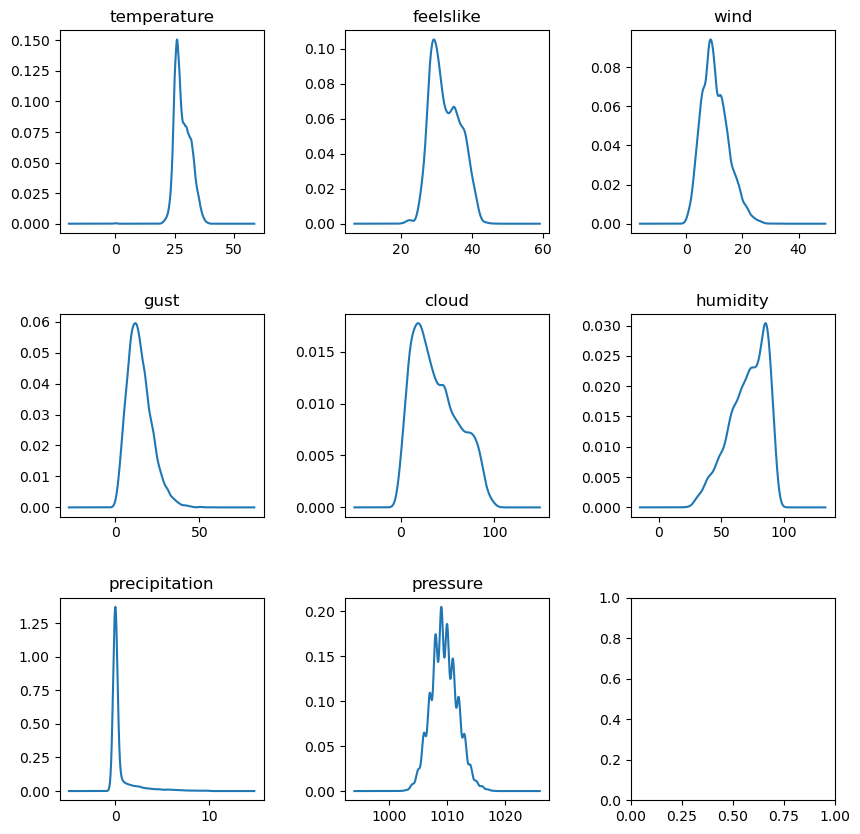

In [3]:
print(data.dtypes)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

num_attr = ['temperature', 'feelslike', 'wind', 'gust', 'cloud', 'humidity', 'precipitation', 'pressure']
for i in  range(len(num_attr)):
    a = num_attr[i]
    data[a].plot(ax=axs[i//3,i%3],kind='kde', xlabel=a)
    axs[i//3,i%3].set_title(a)
    axs[i//3,i%3].set_ylabel("")
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

<Axes: >

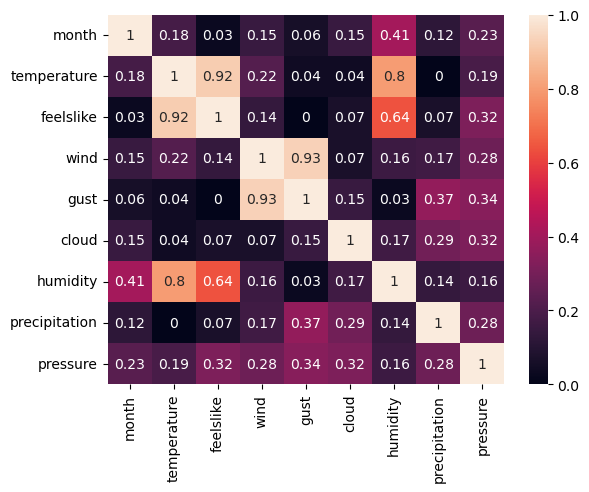

In [4]:
matrix = data.corr(numeric_only=True).abs().round(2)
sns.heatmap(matrix, annot=True)

### DATA TRANSFORMATION

In [5]:
data["target"] = data.shift(-1)["weather"]
data.drop(data.tail(1).index, inplace=True)   

In [6]:
data = data.drop("weather", axis=1)
data = data.drop("precipitation", axis=1)    # Too many values 0 that leads to overfitting

# Change from 16 directions to 8 directions
data['direction'] = data['direction'].replace(['ENE', 'NE', 'NNE'], 'NE')
data['direction'] = data['direction'].replace(['ESE', 'SE', 'SSE'], 'SE')
data['direction'] = data['direction'].replace(['NNW', 'NW', 'WNW'], 'NW')
data['direction'] = data['direction'].replace(['WSW', 'SW', 'SSW'], 'SW')

# Change from time to 2 sessions a day
data['time'] = data['time'].replace(['0:00', '3:00', '6:00', '9:00'], 'earlier')
data['time'] = data['time'].replace(['12:00', '15:00', '18:00', '21:00'], 'later')

# Change from month to seasons
data['month'] = data['month'].replace([1, 2, 3], 'spring')
data['month'] = data['month'].replace([4, 5, 6], 'summer')
data['month'] = data['month'].replace([7, 8, 9], 'autumn')
data['month'] = data['month'].replace([10, 11, 12], 'winter')

In [7]:
data = data.rename(columns={'month': 'season'})

Cloudy                 4294
Light rain             1179
Clear                  1102
Sunny                  1003
Heavy/moderate rain     864
Mist/drizzle             69
Name: target, dtype: int64


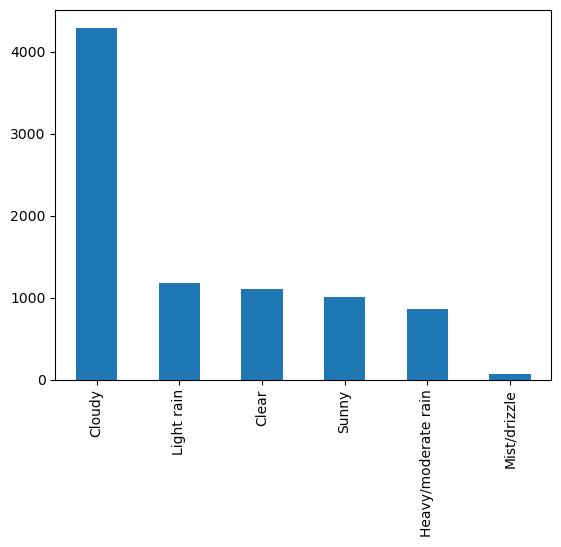

In [8]:
# Transform the label to rain possiblity label
label_map = {
    'Heavy rain at times': 'Heavy/moderate rain',
    'Heavy rain': 'Heavy/moderate rain',
    'Moderate rain at times':'Heavy/moderate rain',
    'Moderate rain':'Heavy/moderate rain',
    'Mist': 'Mist/drizzle',
    'Light drizzle': 'Mist/drizzle',
    'Light rain': 'Light rain',
    'Patchy light drizzle': 'Mist/drizzle',
    'Patchy light rain with thunder': 'Light rain',
    'Patchy light rain': 'Light rain',
    'Torrential rain shower': 'Heavy/moderate rain',
    'Thundery outbreaks possible': 'Cloudy',
    'Overcast': 'Heavy/moderate rain',
    'Light rain shower': 'Light rain',
    'Cloudy': 'Cloudy',
    'Moderate or heavy rain shower': 'Heavy/moderate rain',
    'Patchy rain possible': 'Light rain',
    'Sunny': 'Sunny',
    'Clear': 'Clear',
    'Partly cloudy': 'Cloudy',
}

data['target'] = data['target'].map(label_map)
data['target'].value_counts().plot(kind='bar').plot()

print(data['target'].value_counts())
plt.show()


In [9]:
x = data[['time', 'season', 'temperature', 'feelslike', 'wind', 'direction',
       'gust', 'cloud', 'humidity', 'pressure']].values
y = data['target']


In [10]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import *

num_orders = [2,3,4,6,7,8,9]
cat_orders = [0,1,5]


In [11]:
# Pipeline for categorical data handling
cat_pl= Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),    # Handle missing values with mean value though in this dataset we don't have
           ('onehot', OneHotEncoder(handle_unknown= 'ignore'))]     # Transform categorical data into onehot vectors
        ) 

# Pipeline for numerical data handling
num_pl = Pipeline(
    steps=[
           ('imputer', SimpleImputer(strategy='mean')),             # Handle missing values with forward value though in this dataset we don't have
           ('mmscaler', StandardScaler())]                            # Normalization with MinMaxScaling
         )

In [12]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
                                        ('num', num_pl, num_orders),    # apply cat_pl for categorical columns
                                        ('cat', cat_pl, cat_orders)]    # apply num_pl for numerical columns
               )

### DATA BALANCING

In [13]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
o_spl = SMOTE()

x_encode = preprocessor.fit_transform(x)
x_balanced, y_balanced = o_spl.fit_resample(x_encode, y)

print(y_balanced.value_counts())

Clear                  4294
Sunny                  4294
Cloudy                 4294
Light rain             4294
Heavy/moderate rain    4294
Mist/drizzle           4294
Name: target, dtype: int64


In [14]:
# Complete process data
le = LabelEncoder()
le.fit(['Cloudy', 'Light rain', 'Clear', 'Sunny', 'Heavy/moderate rain', 'Mist/drizzle'])

y_balanced = le.transform(y_balanced) 

### DATA PERFORMANCE

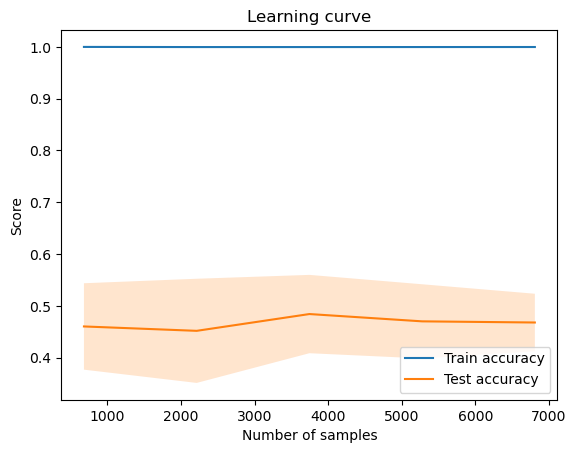

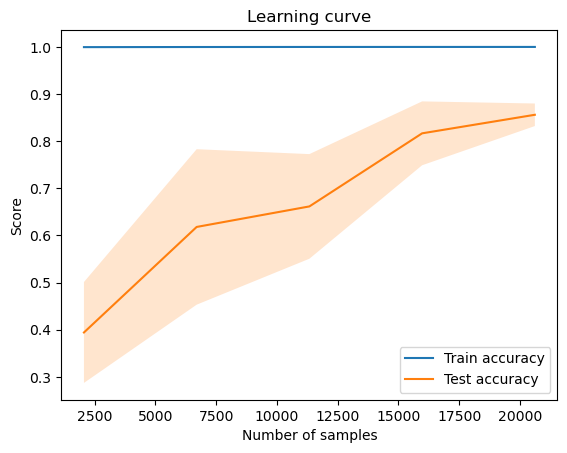

In [15]:
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score

def display_learning_curve(model, x, y):
    train_sizes, train_scores, test_scores = learning_curve(model,x,y)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='Train accuracy')
    plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.2)
    plt.plot(train_sizes, test_mean, label='Test accuracy')
    plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.2)

    plt.title('Learning curve')
    plt.ylabel('Score')
    plt.xlabel('Number of samples')
    plt.legend(loc='lower right')
    plt.show()
display_learning_curve(RandomForestClassifier(),x_encode, y)
display_learning_curve(RandomForestClassifier(),x_balanced, y_balanced)

# MODEL TRAINING AND TESTING

## RANDOM FOREST SECTION

### PARAMETER SEARCH (FOR REPORT ONLY, DO NOT DEMO)

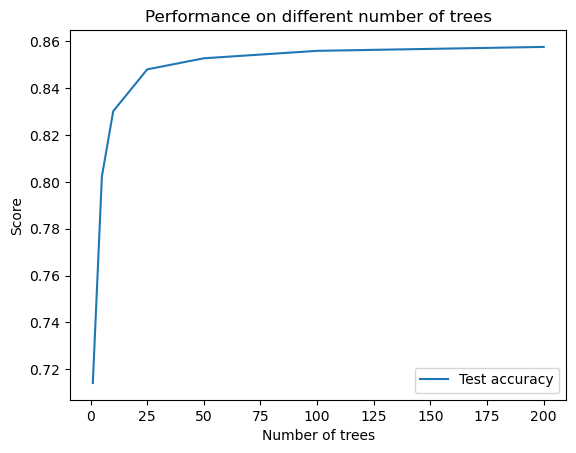

In [16]:
def n_tree_selection_display(x,y):
    param_list = [1, 5, 10, 25, 50, 100, 200]
    y_data = [np.mean(cross_val_score(RandomForestClassifier(n_estimators=i), x, y)) for i in param_list]
    plt.plot(param_list, y_data, label='Test accuracy')

    plt.title('Performance on different number of trees')
    plt.ylabel('Score')
    plt.xlabel('Number of trees')
    plt.legend(loc='lower right')
    plt.show()

n_tree_selection_display(x_balanced, y_balanced)        


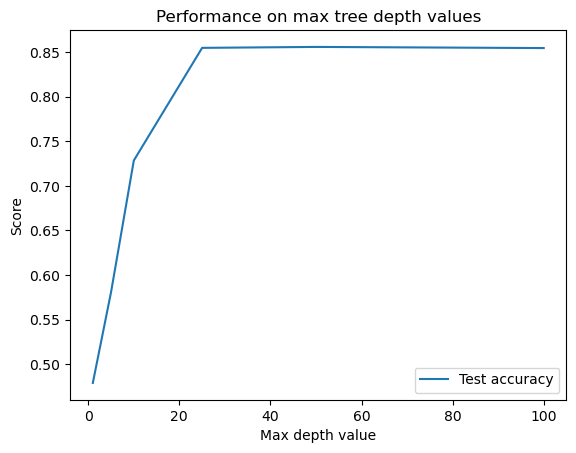

In [17]:
def max_depth_selection_display(x,y):
    param_list = [1, 5, 10, 25, 50, 100]
    y_data = [np.mean(cross_val_score(RandomForestClassifier(max_depth=i), x, y)) for i in param_list]
    plt.plot(param_list, y_data, label='Test accuracy')
    
    plt.title('Performance on max tree depth values')
    plt.ylabel('Score')
    plt.xlabel('Max depth value')
    plt.legend(loc='lower right')
    plt.show()
max_depth_selection_display(x_balanced, y_balanced)        


In [18]:
def criterion_selection_display(x,y):
    param_list = ['gini', 'entropy', 'log_loss']
    y_data = [cross_val_score(RandomForestClassifier(criterion=i), x, y, cv=10) for i in param_list]
    y_mean = np.array(np.mean(y_data, axis=1))
    y_std = np.array(np.std(y_data, axis=1))

    plt.plot(param_list, y_mean, label='Test accuracy')
    plt.fill_between(param_list, y_mean+y_std, y_mean-y_std, alpha=0.2)

    plt.title('Performance on different criterion')
    plt.ylabel('Score')
    plt.xlabel('Max depth value')
    plt.legend(loc='lower right')
    plt.show()
criterion_selection_display(x_balanced, y_balanced)        


KeyboardInterrupt: 

In [ ]:
def min_leaf_selection_display(x,y):
    param_list = [1, 2, 3, 5, 10]
    y_data = [np.mean(cross_val_score(RandomForestClassifier(min_samples_leaf=i), x, y)) for i in param_list]
    plt.plot(param_list, y_data, label='Test accuracy')
    
    plt.title('Performance on min tree leaf values')
    plt.ylabel('Score')
    plt.xlabel('Min leaf value')
    plt.legend(loc='lower right')
    plt.show()

min_leaf_selection_display(x_balanced, y_balanced)        


In [ ]:
def max_features_selection_display(x,y):
    param_list = [1, 2, 5, 10, 15, 20]
    y_data = [np.mean(cross_val_score(RandomForestClassifier(max_features=i), x, y)) for i in param_list]
    plt.plot(param_list, y_data, label='Test accuracy')
    
    plt.title('Performance on max features value')
    plt.ylabel('Score')
    plt.xlabel('Max features value')
    plt.legend(loc='lower right')
    plt.show()

max_features_selection_display(x_balanced, y_balanced)  

### MODEL TRAINING AND TESTING

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size = 0.2, stratify = y_balanced, random_state = 1)
print(x_train.shape, x_test.shape)

(20611, 21) (5153, 21)


Accuracy on train: 1.00


TEST SCORE
Accuracy score: 0.88
Recall score: 0.88
Precision score: 0.88
F1 score: 0.88
ROC AUC score: 0.99


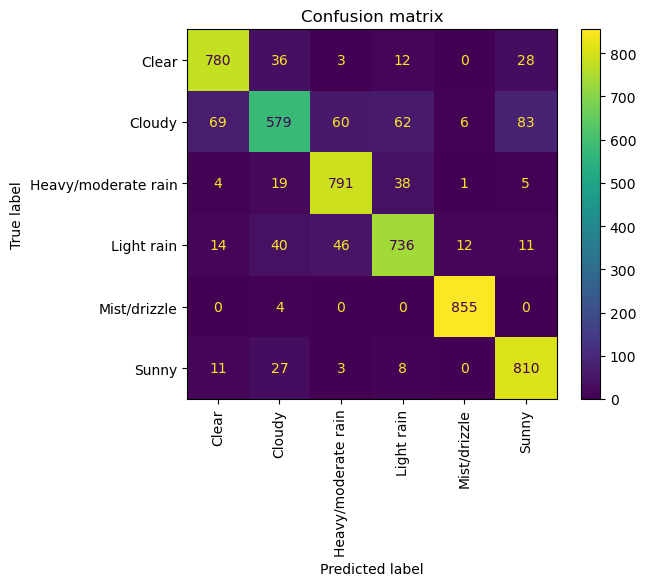

In [20]:
clf = RandomForestClassifier(max_depth=25, criterion='log_loss', max_features=2)

# training
clf.fit(x_train, y_train)

# accuracy
y_train_validate = clf.predict(x_train)
print(f"Accuracy on train: {accuracy_score(list(y_train), list(y_train_validate)):.2f}")

y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)
print('\n\nTEST SCORE')
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.2f}')
print(f'Recall score: {recall_score(y_test, y_pred, average="macro"):.2f}')
print(f'Precision score: {precision_score(y_test, y_pred, average="macro"):.2f}')
print(f'F1 score: {f1_score(y_test, y_pred, average="macro"):.2f}')
print(f'ROC AUC score: {roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovo"):.2f}')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=le.classes_).plot()
plt.xticks(rotation = 90)
plt.title('Confusion matrix')
plt.show()

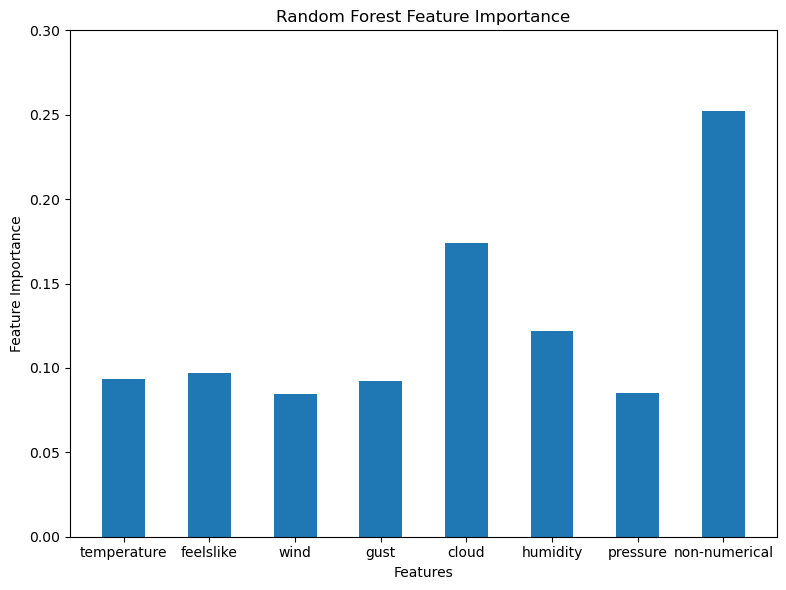

In [21]:
importances = clf.feature_importances_
importances = np.append(importances[:7],sum(importances[7:]))
features_name = ['temperature', 'feelslike', 'wind', 'gust',
         'cloud', 'humidity', 'pressure', 'non-numerical']

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.bar(features_name, importances, align='center', width=0.5)
plt.ylim(0, 0.3)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

## SVM SECTION

In [ ]:
SVM_x_train, SVM_x_test, SVM_y_train, SVM_y_test = train_test_split(x_balanced, y_balanced, test_size = 0.2, stratify = y_balanced, random_state = 2)
print(SVM_x_train.shape, SVM_x_test.shape)


In [ ]:
SVM_clf = SVC(C=100,gamma=2, cache_size=1000, probability=True)

# training
SVM_clf.fit(SVM_x_train, SVM_y_train)

# accuracy
SVM_y_train_validate = SVM_clf.predict(SVM_x_train)
print(f"Accuracy on train: {accuracy_score(list(SVM_y_train), list(SVM_y_train_validate)):.2f}")

SVM_y_pred = SVM_clf.predict(SVM_x_test)
SVM_y_pred_proba = SVM_clf.predict_proba(SVM_x_test)
print('\n\nTEST SCORE')
print(f'Accuracy score: {accuracy_score(SVM_y_test, SVM_y_pred):.2f}')
print(f'Recall score: {recall_score(SVM_y_test, SVM_y_pred, average="macro"):.2f}')
print(f'Precision score: {precision_score(SVM_y_test, SVM_y_pred, average="macro"):.2f}')
print(f'F1 score: {f1_score(SVM_y_test, SVM_y_pred, average="macro"):.2f}')
print(f'ROC AUC score: {roc_auc_score(SVM_y_test, SVM_y_pred_proba, average="macro", multi_class="ovo"):.2f}')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(SVM_y_test, SVM_y_pred), display_labels=le.classes_).plot()
plt.xticks(rotation = 90)
plt.title('Confusion matrix')
plt.show()

## Demo


In [26]:
wdata = pd.read_csv("demo2.csv", sep = ",", names=['time', 'month', 'temperature', 'feelslike', 'wind', 'direction', 'gust', 'cloud', 'humidity', 'precipitation', 'pressure'] )
wdata.drop(0, inplace = True)
wdata[:]

,time,month,temperature,feelslike,wind,direction,gust,cloud,humidity,precipitation,pressure
1,15:00,7,38.0,44.0,5.0,SSE,15.0,14.0,58.0,0.0,1002.0
2,18:00,7,32.0,36.0,6.0,S,14.0,18.0,72.0,1.0,1002.0
3,21:00,7,29.0,30.0,9.0,S,19.0,15.0,81.0,1.0,1005.0
4,0:00,7,29.0,31.3,5.0,SE,10.0,15.0,89.0,0.0,1005.0
5,3:00,7,28.0,30.0,3.0,ENE,6.0,14.0,92.0,0.0,1004.0
6,6:00,7,27.0,29.0,2.0,ENE,5.0,14.0,92.0,0.0,1005.0
7,9:00,7,31.0,35.0,3.0,S,8.0,17.0,77.0,0.0,1006.0
8,12:00,7,34.0,41.0,3.0,S,12.0,13.0,63.0,0.0,1004.0


In [28]:
# Change from 16 directions to 8 directions
wdata['direction'] = wdata['direction'].replace(['ENE', 'NE', 'NNE'], 'NE')
wdata['direction'] = wdata['direction'].replace(['ESE', 'SE', 'SSE'], 'SE')
wdata['direction'] = wdata['direction'].replace(['NNW', 'NW', 'WNW'], 'NW')
wdata['direction'] = wdata['direction'].replace(['WSW', 'SW', 'SSW'], 'SW')

# Change from time to 2 sessions a day
wdata['time'] = wdata['time'].replace(['0:00', '3:00', '6:00', '9:00'], 'earlier')
wdata['time'] = wdata['time'].replace(['12:00', '15:00', '18:00', '21:00'], 'later')

wdata['month'] = wdata['month'].replace([1, 2, 3], 'spring')
wdata['month'] = wdata['month'].replace([4, 5, 6], 'summer')
wdata['month'] = wdata['month'].replace([7, 8, 9], 'autumn')
wdata['month'] = wdata['month'].replace([10, 11, 12], 'winter')

wdata = wdata.drop("precipitation", axis=1)

wdata = wdata.rename(columns={'month': 'season'})

x = wdata[['time', 'season', 'temperature', 'feelslike', 'wind', 'direction',
       'gust', 'cloud', 'humidity', 'pressure']].values
x_encode = preprocessor.transform(x)
result = clf.predict(x_encode)

KeyError: 'month'

In [30]:
print(le.inverse_transform(result))

['Cloudy' 'Clear' 'Light rain' 'Cloudy' 'Cloudy' 'Sunny' 'Cloudy' 'Cloudy']
